In [1]:
import mujoco
import cv2
import numpy as np
import yaml
import pickle
import pathlib
import pickle
import mujoco.viewer
from operator import index
import pinocchio as pin
from pinocchio.utils import *
import numpy as np
from numpy.linalg import norm, solve
import time
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm, markers
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ipywidgets import widgets, interact
from scipy.optimize import least_squares
import time

In [2]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
class DMP():
    def __init__(self, X, X_dot, X_ddot, t, goal, bf_number,k, d, conv_rate):
        
        self.t = t
        self.dt = 0.05
        self.X = X
        self.X_dot = X_dot
        self.X_ddot = X_ddot
        self.goal = goal
        
        self.bf_number = bf_number
        self.feature_length = self.X.shape[0]
        self.feature_count = self.X.shape[1]
        
        self.K = k*np.identity(self.feature_count)
        self.D = d*np.identity(self.feature_count)
        self.conv_rate = conv_rate
        self.alpha = -np.log(self.conv_rate)
        self.tau = self.t[-1]
        self.s = np.exp((-self.alpha/self.tau)*self.t)
        
        self.v = self.tau*self.X_dot
        self.v_dot = self.tau*self.X_ddot
        self.tau_v_dot = self.tau*self.v_dot
        
        self.K_inv = np.linalg.inv(self.K)

        self.theta = None

        self.Dv = np.zeros(shape=self.X.shape)
        for i in range(self.feature_length):
            self.Dv[i] = self.D@self.v[i]
        
        self.f_target = np.zeros(shape=self.X.shape)
        for i in range(self.feature_length):
            self.f_target[i] = self.tau_v_dot[i] + self.Dv[i] + self.K@(self.X[i] - self.goal)

    def learn_weights(self):
        self.ci= np.logspace(-3, 0, num=self.bf_number)
        # self.ci= np.linspace(0.001, 1, num=self.bf_number)
        self.h = self.bf_number / (self.ci ** 2)
        ci_tile = np.tile(self.ci[None],(self.feature_length,1))
        s = np.tile(self.s[:,None], (1, self.bf_number))
        self.psi_matrix = np.exp(-self.h * (s - ci_tile) ** 2)
        self.inv_sum_bfs = 1.0 / np.sum(self.psi_matrix, axis=-1)
        
        self.bf_target = np.einsum('lb,l->lb',self.psi_matrix*s,self.inv_sum_bfs)
        print(self.bf_target.shape)
        print(self.f_target.shape)
        sol = np.linalg.lstsq(self.bf_target,self.f_target,rcond=None)
        self.theta = sol[0]
        print('Theta is leaned using LWR. Shape => ', self.theta.shape)

    def get_theta(self):
        return self.theta

    def set_theta(self, value):
        self.theta = value

    def get_g(self, ind):
        return self.bf_target[ind]

    def get_g_all(self):
        return self.bf_target
    
    def rollout(self, time, dt, des_tau, g, x, x_dot):
        s = np.exp(((-self.alpha / des_tau) * time))
        psi = np.exp(-self.h * ((s - self.ci) ** 2))
        sum_of_bfs = np.sum(psi)
        fs_nom = np.sum(np.einsum('bj,b->bj', self.theta, psi), axis=0)
        fs = (fs_nom / sum_of_bfs) * s
        # f = self.psi_matrix[ind]@theta
        # f *= self.inv_sum_bfs[ind]
        # f *= self.s[ind]

        v = self.tau * x_dot
        v_dot = (1.0 / self.tau) * (np.dot(self.K, self.goal - x) - np.dot(self.D, v) + fs)
        v = v + v_dot * self.dt
        x_dot = v / self.tau
        x = x + x_dot * self.dt

        return x, x_dot

        
    

In [9]:
MVN = multivariate_normal(np.array([0, 0]),np.identity(2))
x = np.array([0, 0])

t0 = time.time()
p = MVN.pdf(x)
t1 = time.time()
print(t1-t0)
print(p)

t0 = time.time()
p = (1/((2*np.pi)))*(np.linalg.det(np.identity(2))**(-0.5))*np.exp(-0.5*(x-np.array([0, 0])).T.dot(np.identity(2)).dot(x-np.array([0, 0])))
t1 = time.time()
print(t1-t0)
print(p)

0.00013780593872070312
0.15915494309189535
0.00019121170043945312
0.15915494309189535


In [10]:
class cost_calculator():
    def __init__(self, Mu, Sigma, Goal, dmp):
        self.num_g = len(Mu)
        self.Mu = Mu
        self.Sigma = Sigma
        self.dmp = dmp
        self.Goal = Goal
        self.bf_number = self.dmp.bf_number
        self.feature_count = self.dmp.feature_count
        self.feature_length = self.dmp.feature_length
        self.R = np.identity(self.bf_number)*100
        self.R_inv = np.linalg.inv(self.R)
        self.Lambda = 10
        self.h = 10
        self.exp_k = 3
        self.exp_mean = np.zeros(shape=(self.bf_number))
        # self.exp_cov = self.Lambda*self.R_inv
        self.exp_cov = np.identity(self.bf_number)*10
        self.dt = 0.05
        self.des_tau = self.dmp.tau
        self.num_cost = 5
        self.exp_noise = np.random.multivariate_normal(self.exp_mean, self.exp_cov, (self.feature_length, self.exp_k, self.feature_count))
        self.S = np.zeros(shape=(self.feature_length-1,self.exp_k))
        self.P = np.zeros(shape=self.S.shape)
        self.d_theta = np.zeros(shape=(self.feature_length-1, self.bf_number, self.feature_count))
        self.traj_mean = np.zeros(shape=(self.feature_count))
        self.traj_cov = np.identity(self.feature_count)*0.05
        self.traj_noise = np.random.multivariate_normal(self.traj_mean, self.traj_cov, (self.feature_length, self.exp_k, self.feature_count))
        self.SD_cost_num = 5
        self.mvns = []
        self.f_sets = []
        self.compute_M()
        self.compute_SD_cost_fcn()
        
    def compute_SD_cost_fcn(self):
        for i in range(self.SD_cost_num):
            f_set = [2*(i-1),2*(i-1)+1]
            self.mvns.append(multivariate_normal(self.Mu[i],self.Sigma[i]))
            self.f_sets.append(f_set)
    
    def feature_cost(self, x, feature_set):
        cost = 0
        for i in self.f_sets[feature_set-1]:
            cost += self.mvns[feature_set-1].pdf(x)
        cost = cost/len(self.f_sets[feature_set-1])
        # return cost*self.dt
        return cost

    def terminal_cost(self, x, e):
        cost = 0
        if norm(self.Goal - x) < e:
            cost = 1
        return cost

    def compute_dmp_cost(self, theta, g, e, M):
        U = theta + M.dot(e.T)
        cost = 0.5*U.T.dot(self.R).dot(U)
        return cost

    def compute_M(self):
        self.M = np.zeros(shape=(self.feature_length,self.bf_number,self.bf_number))
        for i in range(self.feature_length):
            g = self.dmp.get_g(i).reshape(-1,1)
            self.M[i] = self.R_inv.dot(g).dot(g.T)/(g.T.dot(self.R_inv).dot(g))
    
    def compute_S(self, ind, beta):
        S = np.zeros(shape=(self.feature_length,self.exp_k,self.num_cost + self.feature_count + 1))
        # P = np.zeros(shape=S.shape)
        for i in range(ind, self.feature_length-1):
            g = self.dmp.get_g(i)
            M = self.M[i]
            time = self.dmp.t[i]
            for k in range(self.exp_k):
                c = 0
                # e = self.exp_noise[i,k]
                # theta = self.dmp.get_theta()
                # U = theta + M.dot(e.T)
                e = self.traj_noise[i,k]
                noisy_x = self.dmp.X[ind]+e[0]
                noisy_xd = self.dmp.X_dot[ind]+e[1]
                x_rollout, _ = self.dmp.rollout(time, self.dt, self.des_tau, self.Goal, noisy_x, noisy_xd)
                for j in range(self.num_cost):
                    S[i,k,c] += self.feature_cost(x_rollout,j+1)
                    c += 1
                for j in range(self.feature_count):
                    # e = self.exp_noise[i,k,j]
                    # theta = self.dmp.get_theta()[:,j]
                    # S[i,k,c] += self.compute_dmp_cost(theta,g,e,M)
                    # S[i,k,c] = 0 # For testing purposes
                    c += 1
                S[i,k,-1] += self.terminal_cost(x_rollout, 0.1)
                self.S[i,k] = beta.T.dot(S[i,k].reshape(-1,1))
        # print('Computing S_i at time index ', ind+1) 

    def compute_P(self):
        for i in range(self.feature_length-1):
            inv_range_S = 1/(np.max(self.S[i]) - np.min(self.S[i]))
            diff_S = self.S[i] - np.min(self.S[i])
            exp_S = np.exp(-self.h*(diff_S*inv_range_S))
            # exp_S = np.exp((-1/self.Lambda)*self.S[i])
            sum_S = np.sum(exp_S,axis=0)
            self.P[i] = exp_S/sum_S
        # print("Done Computing P !")

    def compute_d_theta_i(self):
        for i in range(self.feature_length-1):
            d = 0
            for k in range(self.exp_k):
                M = self.M[i]
                d += self.P[i,k]*(M.dot(self.exp_noise[i,k].T))
            self.d_theta[i] = d
        # print("Done Computing d_Theta !")
                
    def get_S(self):
        return self.S

    def get_P(self):
        return self.P

    def get_d_theta(self):
        return self.d_theta

    def set_S(self, value):
        self.S = value

    def set_P(self, value):
        self.P = value

    def set_d_theta(self, value):
        self.d_theta = value

            

In [11]:
t = data['time']
X = data['X']
X_dot = data['X_dot']
X_ddot = data['X_ddot']
x0 = data['x0']
goal = data['goal']
num_g = data['num_g']
num_data = data['num_data']
cost_mu = data['cost_mu']
cost_sigma = data['cost_sigma']
init_cost = data['cost']

In [20]:
init_cost.shape

(100, 100)

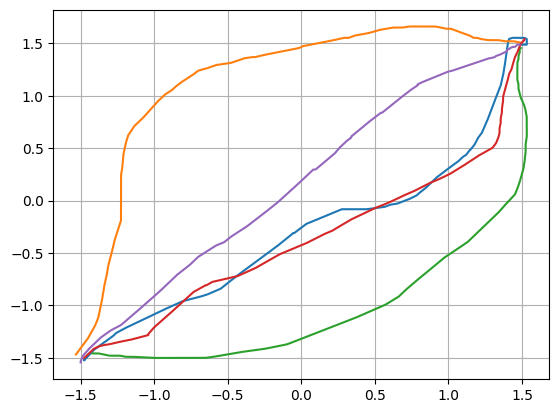

In [12]:
for i in range(5):
    plt.plot(X[i,:,0],X[i,:,1])
plt.grid(visible=True)
plt.show()

In [13]:
ref = np.linspace(0,X.shape[1]-1,100,dtype=int)
demo_num = 0
t = t[demo_num,ref]
X = X[demo_num,ref,:]
X_dot = X_dot[demo_num,ref,:]
X_ddot = X_ddot[demo_num,ref,:]
bf_number = 30
feature_length = X.shape[0]
feature_count = X.shape[1]
des_tau = t[-1]
dt = np.diff(t)[0]
k = 1500
d = 2*np.sqrt(k)
# d  = 50
conv_rate = 0.01

dmp = DMP(X, X_dot, X_ddot, t, goal, bf_number, k=k, d=d, conv_rate=conv_rate)
dmp.learn_weights()
weights = dmp.get_theta()
# print(weights)

(100, 30)
(100, 2)
Theta is leaned using LWR. Shape =>  (30, 2)


In [15]:
T = 0
x = x0
# dt = 0.01
# des_tau = 5
x_dot = np.zeros_like(x0)
x_holder = [x0]
x_dot_holder = [x_dot]
t_roll = [0]
while T <= des_tau:
    x, x_dot = dmp.rollout(T, dt, des_tau, goal, x, x_dot)
    T += dt
    x_holder.append(x)
    x_dot_holder.append(x_dot)
    t_roll.append(T)

x_roll = np.stack(x_holder)
x_dot_roll = np.stack(x_dot_holder)
t_roll = np.stack(t_roll)


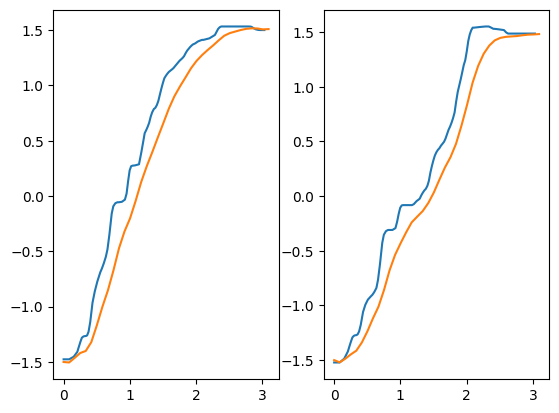

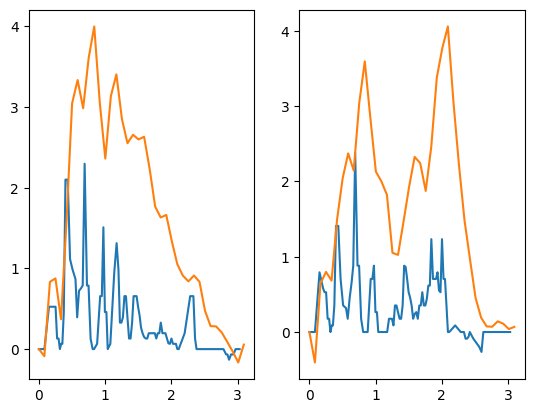

In [16]:
plt.subplot(1,2,1)
plt.plot(t,X[:,0])
plt.plot(t_roll,x_roll[:,0])
# plt.show()
plt.subplot(1,2,2)
plt.plot(t,X[:,1])
plt.plot(t_roll,x_roll[:,1])

plt.show()

plt.subplot(1,2,1)
plt.plot(t,X_dot[:,0])
plt.plot(t_roll,x_dot_roll[:,0])
# plt.show()
plt.subplot(1,2,2)
plt.plot(t,X_dot[:,1])
plt.plot(t_roll,x_dot_roll[:,1])
plt.show()

In [17]:
SD_cost_num = 5
beta = np.random.rand(SD_cost_num + feature_count + 1)
print(beta)
Cost = cost_calculator(cost_mu, cost_sigma, goal, dmp)
time_start = time.time()
for i in range(feature_length-1):
    Cost.compute_S(i,beta)

Cost.compute_P()
# Cost.compute_d_theta_i()
time_finish = time.time()

print('Duration: ',time_finish-time_start, ' seconds')

[0.14993078 0.94985566 0.88640248 0.73696817 0.79964205 0.90923402
 0.16844665 0.88092604]


/tmp/ipykernel_7804/42864282.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.S[i,k] = beta.T.dot(S[i,k].reshape(-1,1))


Duration:  4.155431747436523  seconds


In [18]:
S = Cost.get_S()
P = Cost.get_P()
# d_theta = Cost.get_d_theta()

In [19]:
P

array([[1.92726628e-04, 4.53891193e-05, 9.99761884e-01],
       [1.84309661e-04, 9.99770301e-01, 4.53895014e-05],
       [2.52172579e-02, 4.42530589e-05, 9.74738489e-01],
       [9.91794007e-01, 4.50273783e-05, 8.16096539e-03],
       [5.80674950e-02, 4.27617282e-05, 9.41889743e-01],
       [7.44393279e-03, 9.92511007e-01, 4.50599300e-05],
       [9.99791840e-01, 1.62769590e-04, 4.53904793e-05],
       [4.49028336e-05, 1.09043690e-02, 9.89050728e-01],
       [1.73801252e-04, 4.53899785e-05, 9.99780809e-01],
       [2.58550590e-01, 3.36602230e-05, 7.41415750e-01],
       [8.26710326e-05, 9.99871935e-01, 4.53941156e-05],
       [7.59034036e-03, 4.50532834e-05, 9.92364606e-01],
       [4.53667810e-05, 9.99269851e-01, 6.84782503e-04],
       [4.65682102e-01, 2.42568938e-05, 5.34293641e-01],
       [3.53245290e-05, 2.21890146e-01, 7.78074529e-01],
       [9.68915859e-01, 3.10401524e-02, 4.39887119e-05],
       [9.99264686e-01, 4.53665465e-05, 6.89947727e-04],
       [4.53863410e-05, 9.99700

In [20]:
beta = np.random.rand(SD_cost_num + feature_count + 1)
beta = beta/np.sum(beta)
print(beta)
w = np.zeros(shape=(feature_length-1,1))
for i in range(feature_length-1):
    w[i] = feature_length - i
sum_w = np.sum(w)
w = w/sum_w
gamma = 0.1

def opt_fcn(beta):
    fcn = 0
    for j in range(feature_length-1):
        Cost.compute_S(j,beta)
    Cost.compute_P()
    Cost.compute_d_theta_i()
    dth = Cost.get_d_theta()
    dth = np.concatenate((dth[:,:,0],dth[:,:,1]),axis=1)
    for i in range(feature_length-1):
        fcn += (w[i] ** 2)*dth[i].reshape(-1,1).T.dot(dth[i].reshape(-1,1))
    fcn += gamma*(beta.reshape(-1,1).T.dot(beta.reshape(-1,1)))
    fcn = fcn.reshape(-1)
    return fcn

res = least_squares(opt_fcn, beta, max_nfev=100, verbose=2)

[0.01863275 0.17957956 0.14529907 0.13446504 0.1368109  0.19398113
 0.118314   0.07291756]


/tmp/ipykernel_7804/42864282.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.S[i,k] = beta.T.dot(S[i,k].reshape(-1,1))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2301e-02                                    1.87e-02    
       1              2         2.6701e-02      5.60e-03       3.84e-01       1.14e-02    
       2              5         2.6336e-02      3.65e-04       2.40e-02       8.83e-03    
       3              6         2.6254e-02      8.20e-05       4.80e-02       1.08e-02    
       4              7         2.6092e-02      1.62e-04       1.20e-02       1.19e-02    
       5              8         2.5823e-02      2.69e-04       2.40e-02       1.82e-02    
       6              9         2.5804e-02      1.88e-05       4.80e-02       1.80e-02    
       7             10         2.5263e-02      5.42e-04       1.20e-02       2.68e-02    
       8             13         2.5240e-02      2.22e-05       1.50e-03       1.07e-02    
       9             14         2.5230e-02      1.07e-05       1.50e-03       1.81e-02    

In [21]:
print(beta)
print(res.x)
print(res.cost)
print(res.optimality)

[0.01863275 0.17957956 0.14529907 0.13446504 0.1368109  0.19398113
 0.118314   0.07291756]
[ 0.0349043  -0.09686102 -0.01865891  0.08898931  0.06761915  0.02298489
  0.01401906  0.0224366 ]
0.025176256222814285
0.009184961686576013


In [22]:
SD_cost_num = 5
beta = np.random.rand(SD_cost_num + feature_count + 1)
beta = beta/np.sum(beta)
print(beta)
w = np.zeros(shape=(feature_length-1,1))
for i in range(feature_length-1):
    w[i] = feature_length - i
sum_w = np.sum(w)
w = w/sum_w
gamma = 3

def opt_fcn_2(beta):
    fcn = 0
    for j in range(feature_length-1):
        Cost.compute_S(j,beta)
    Cost.compute_P()
    P = Cost.get_P()
    sum_P = np.sum(P,axis=-1)
    
    for i in range(feature_length-1):
        fcn -= ((w[i] ** 2)*np.sum(np.log(P[i]/sum_P[i]))).reshape(-1,1)
        # fcn -= (np.sum(np.log(P[i]/sum_P[i]))).reshape(-1,1)
    fcn += gamma*(beta.reshape(-1,1).T.dot(beta.reshape(-1,1)))
    fcn = fcn.reshape(-1)
    # print(beta)
    return fcn

res2 = least_squares(opt_fcn_2, beta,max_nfev=100, verbose=2)

[0.1350423  0.09508872 0.07066329 0.09129572 0.19412026 0.11609843
 0.18229741 0.11539386]


/tmp/ipykernel_7804/42864282.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.S[i,k] = beta.T.dot(S[i,k].reshape(-1,1))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8810e-01                                    7.24e-01    
       1              2         1.9414e-02      1.69e-01       3.72e-01       1.04e-01    
       2              6         1.8786e-02      6.28e-04       1.16e-02       1.08e+00    
       3             10         1.8571e-02      2.15e-04       1.82e-04       1.35e+00    
       4             12         1.8436e-02      1.34e-04       9.08e-05       1.40e+00    
       5             14         1.8393e-02      4.32e-05       4.54e-05       5.37e-02    
       6             17         1.8393e-02      1.86e-07       2.84e-06       5.38e-02    
       7             18         1.8393e-02      1.76e-07       2.84e-06       5.61e-02    
       8             19         1.8393e-02      1.75e-07       2.84e-06       6.15e-02    
       9             20         1.8392e-02      1.70e-07       2.84e-06       5.91e-02    

In [23]:
print(beta)
print(res2.x)
print(res2.cost)
print(res2.optimality)

[0.1350423  0.09508872 0.07066329 0.09129572 0.19412026 0.11609843
 0.18229741 0.11539386]
[ 6.53407364e-03 -1.50460348e-03 -1.89071719e-03  4.34932171e-03
 -8.96819284e-03  1.05337236e-05  1.65452552e-05 -2.99772744e-03]
0.018372386484863112
0.08102380079083536


In [24]:
num_data = 100
x_range = np.linspace(-2.,2.,num_data)
y_range = np.linspace(-2.,2.,num_data)
init_cost = np.zeros(shape=(len(x_range), len(y_range)))


for i in range(len(x_range)):
    for j in range(len(y_range)):
        for k in range(10):
            var = multivariate_normal(cost_mu[k], cost_sigma[k])
            init_cost[i,j] += var.pdf(np.array([x_range[i],y_range[j]]).T)
init_cost = init_cost/10

In [25]:
new_cost = np.zeros(shape=(len(x_range), len(y_range)))
new_cost_2 = np.zeros(shape=(len(x_range), len(y_range)))
solved_beta = res.x[:5]
solved_beta_2 = res2.x[:5]
for i in range(len(x_range)):
    for j in range(len(y_range)):
        for k in range(SD_cost_num):
            new_cost[i,j] += Cost.feature_cost(np.array([x_range[i],y_range[j]]).T,k+1)*solved_beta[k]
            new_cost_2[i,j] += Cost.feature_cost(np.array([x_range[i],y_range[j]]).T,k+1)*solved_beta_2[k]



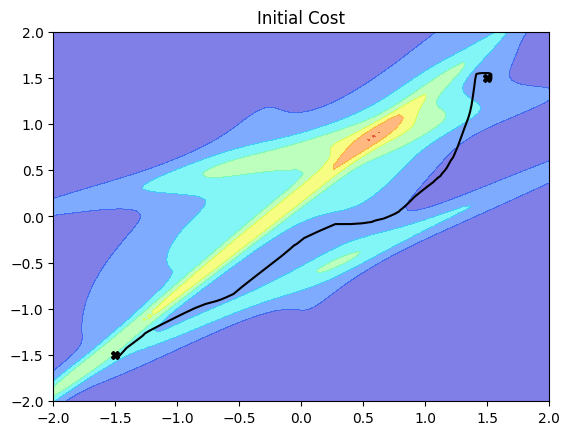

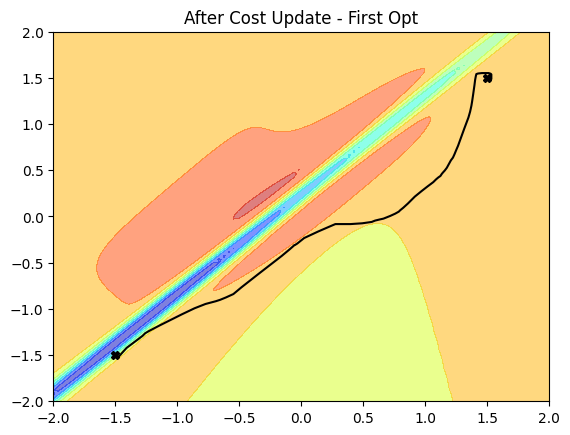

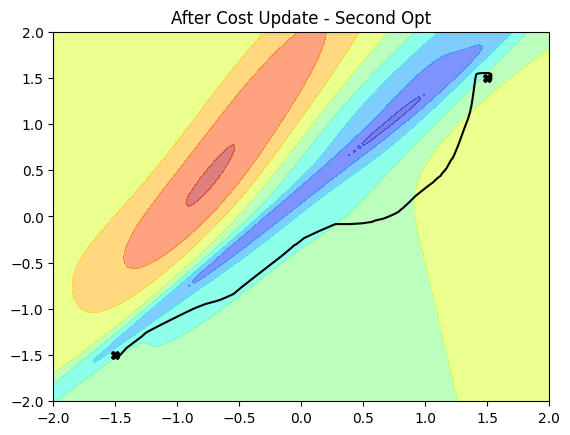

In [26]:
# plt.subplot(2,1,1)
plt.contourf(x_range,y_range,init_cost,alpha=0.5, cmap=cm.jet)
plt.plot(x0[0],x0[1],marker='X',color='black')
plt.plot(goal[0],goal[1], marker='X', color='black')
plt.plot(X[:,0],X[:,1],color='black')
plt.title('Initial Cost')
plt.show()
# plt.subplot(2,1,2)
plt.contourf(x_range,y_range,new_cost,alpha=0.5, cmap=cm.jet)
plt.plot(x0[0],x0[1],marker='X',color='black')
plt.plot(goal[0],goal[1], marker='X', color='black')
plt.plot(X[:,0],X[:,1],color='black')
plt.title('After Cost Update - First Opt')
plt.show()

plt.contourf(x_range,y_range,new_cost_2,alpha=0.5, cmap=cm.jet)
plt.plot(x0[0],x0[1],marker='X',color='black')
plt.plot(goal[0],goal[1], marker='X', color='black')
plt.plot(X[:,0],X[:,1],color='black')
plt.title('After Cost Update - Second Opt')
plt.show()
